<center>
<img align="left" src="https://thumbs.dreamstime.com/b/casa-dos-desenhos-animados-para-venda-53745307.jpg" width="20%" height="20%">
<br>
<br>
<br>
<h1>House Prices: Advanced Regression Techniques</h1>
<h3>Kaggle Competition</h3>
</center>

In [545]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error

<h2>Importing data from Kaggle</h2>

In [546]:
train = pd.DataFrame(pd.read_csv('train.csv'))
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [547]:
test = pd.DataFrame(pd.read_csv('test.csv'))
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<h2>Cleaning Data</h2>

In [548]:
'''Number of elements null in each column'''
total_missing = train.isnull().sum()
total_missing.head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [549]:
'''Select empty columns'''
to_delete = total_missing[total_missing>(train.shape[0]/3.)]
print(to_delete)

'''Delete empty columns'''
tables = [train,test]
for table in tables:
    table.drop(list(to_delete.index),axis=1,inplace=True)

Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


<h2>Functions for prediction</h2>

In [550]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better=False)

In [551]:
def data_preprocess(train,test):
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))
    train["SalePrice"] = np.log1p(train["SalePrice"])
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    all_data = pd.get_dummies(all_data)
    all_data = all_data.fillna(all_data.mean())
    X_train = all_data[:train.shape[0]]
    X_test = all_data[train.shape[0]:]
    y = train.SalePrice
    return X_train,X_test,y

In [552]:
def model_linear_regression(Xtrain,Xtest,ytrain):
    '''Solution Inspired by 
    https://github.com/Shitao/Kaggle-House-Prices-Advanced-Regression-Techniques'''
    X_train = Xtrain
    y_train = ytrain
    etr = LinearRegression(n_jobs=1)
    param_grid = {}
    model = GridSearchCV(estimator=etr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Best CV Score:')
    print(-model.best_score_)
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [553]:
def result(prediction,score):
    '''Create the .csv with id and predicted Sale Price for submission'''
    now = datetime.datetime.now()
    sub_file = 'submission_result.csv'
    pd.DataFrame({'Id': test['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

<h2>Running the Algoritm</h2>

In [554]:
Xtrain,Xtest,ytrain = data_preprocess(train,test)
test_predict, score = model_linear_regression(Xtrain,Xtest,ytrain)
result(np.exp(test_predict),score)

Best CV Score:
0.132625801251


In [555]:
predictData = pd.DataFrame(pd.read_csv('submission_result.csv'))
predictData.head()

,Id,SalePrice
0,1461,121685.498267
1,1462,156404.027208
2,1463,189623.029572
3,1464,200369.243448
4,1465,200366.170265


<h2>Stats</h2>


<h3>Validating the Method</h3>


In [557]:
def result2(prediction,score,df):
    '''Create the .csv with id and predicted Sale Price for submission'''
    now = datetime.datetime.now()
    sub_file = 'regressionlinear_train.csv'
    pd.DataFrame({'Id': df['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

In [558]:
train_origin = pd.DataFrame(pd.read_csv('train.csv'))
qLinhas = len(train_origin.index)
validation = pd.DataFrame(train_origin.iloc[qLinhas/2:,0:])
validation.columns = train_origin.columns
validation = validation.drop(['SalePrice'],axis=1)
validation.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
730,731,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
731,732,80,RL,73.0,9590,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
732,733,60,RL,75.0,11404,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
733,734,20,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,Shed,400,3,2009,WD,Normal
734,735,20,RL,NaN,8978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Family


In [559]:
new_train = pd.DataFrame(train_origin.iloc[0:qLinhas,0:])
new_train.columns = train_origin.columns
new_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [560]:
xTrain,xTeste,yTrain = data_preprocess(new_train,validation)
test_pred, scor = model_linear_regression(xTrain,xTeste,yTrain)
result2(np.exp(test_pred),scor,validation)

Best CV Score:
0.170707386304


In [561]:
predict_train = pd.DataFrame(pd.read_csv('regressionlinear_train.csv'))
predict_train.head()

,Id,SalePrice
0,731,249252.134308
1,732,197997.680664
2,733,226821.135790
3,734,135038.939300
4,735,106859.641877


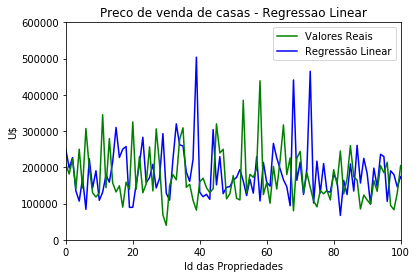

In [585]:
# -*- coding: utf-8 -*-
def stat2(df):
    y_pred = df["SalePrice"]
    y_train = train_origin["SalePrice"]
    plt.title('Preco de venda de casas - Regressao Linear')
    plt.ylabel('U$')
    plt.xlabel(u'Id das Propriedades')
    reg_val, = plt.plot(y_pred,color='b',label=u'Regressão Linear')
    true_val, = plt.plot(y_train,color='g', label='Valores Reais')
    plt.xlim([0,100])
    plt.ylim([0,600000])
    plt.legend(handles=[true_val,reg_val])
    plt.show()
stat2(predict_train)

<h3>Describe</h3>

In [622]:
print(predict_train["SalePrice"].describe())
print('\n')
print(new_train["SalePrice"].describe())

count       730.000000
mean     177436.223501
std       71292.164029
min       37635.712620
25%      130982.532978
50%      162988.892069
75%      208374.871528
max      695647.435552
Name: SalePrice, dtype: float64


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<h3>Histograms</h3>

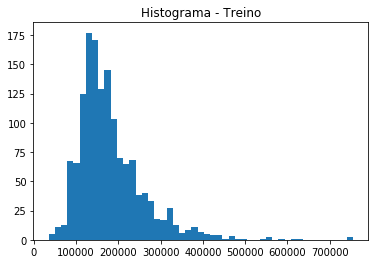

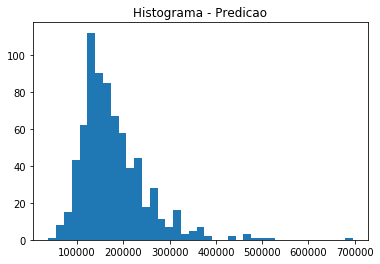

In [626]:
def hist(a,df,title):
    plt.hist(a, bins='auto')
    plt.title(title)
    plt.show()
hist(new_train["SalePrice"],new_train,"Histograma - Treino")
hist(predict_train["SalePrice"],predict_train,"Histograma - Predicao")

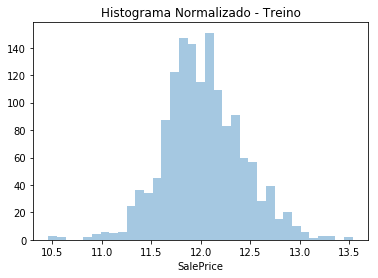

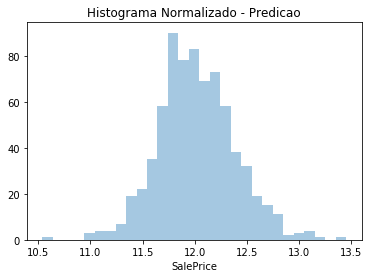

In [627]:
def histNormal(a,df,title):
    sns.distplot(np.log(df['SalePrice']),kde=False)
    plt.title(title)
    plt.show()
histNormal(new_train["SalePrice"],new_train,"Histograma Normalizado - Treino")
histNormal(predict_train["SalePrice"],predict_train,"Histograma Normalizado - Predicao")

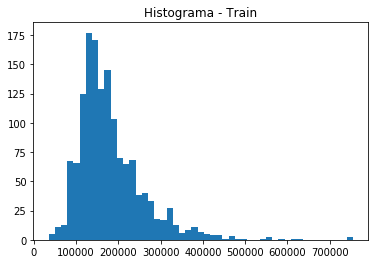

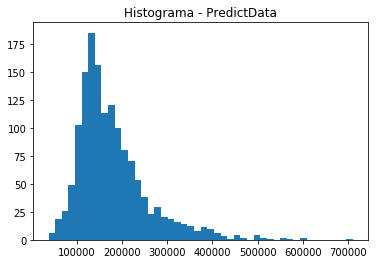

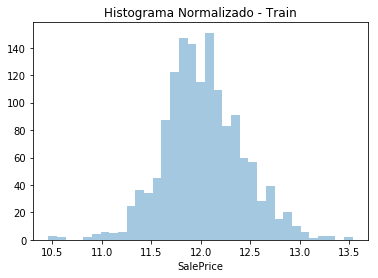

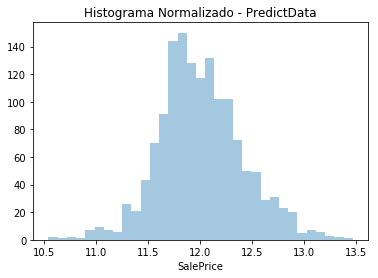

In [638]:
hist(train_origin["SalePrice"],train_origin,"Histograma - Train")
hist(predictData["SalePrice"],predictData,"Histograma - PredictData")
histNormal(train_origin["SalePrice"],train_origin,"Histograma Normalizado - Train")
histNormal(predictData["SalePrice"],predictData,"Histograma Normalizado - PredictData")

In [642]:
print(train_origin["SalePrice"].describe())
print('\n')
print(predictData["SalePrice"].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


count      1459.000000
mean     179301.883845
std       80678.728777
min       37895.287254
25%      126396.018961
50%      159933.325464
75%      210413.338708
max      710345.590268
Name: SalePrice, dtype: float64


<h3>Others Regression Techiniques</h3>

In [569]:
def model_random_forecast(Xtrain,Xtest,ytrain):
    '''Solution by https://github.com/Shitao/Kaggle-House-Prices-Advanced-Regression-Techniques'''
    X_train = Xtrain
    y_train = ytrain
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {}#'n_estimators': [500], 'max_features': [10,15,20,25], 'max_depth':[3,5,7,9,11]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Random forecast regression...')
    print('Best CV Score:')
    print(-model.best_score_)

    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

def model_gradient_boosting_tree(Xtrain,Xtest,ytrain):
    '''Solution by https://github.com/Shitao/Kaggle-House-Prices-Advanced-Regression-Techniques'''
    X_train = Xtrain
    y_train = ytrain 
    gbr = GradientBoostingRegressor(random_state=0)
    param_grid = {}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=10, scoring=RMSE)
    model.fit(X_train, y_train)
    print('Gradient boosted tree regression...')
    print('Best CV Score:')
    print(-model.best_score_)

    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [570]:
def result3(prediction,score):
    '''Create the .csv with id and predicted Sale Price for submission'''
    now = datetime.datetime.now()
    sub_file = 'result_randomforecast.csv'
    pd.DataFrame({'Id': validation['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

def result4(prediction,score):
    '''Create the .csv with id and predicted Sale Price for submission'''
    now = datetime.datetime.now()
    sub_file = 'result_bostingtree.csv'
    pd.DataFrame({'Id': validation['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)

In [571]:
test_pred, scor = model_random_forecast(xTrain,xTeste,yTrain)
result3(np.exp(test_pred),scor)

test_pred, scor = model_gradient_boosting_tree(xTrain,xTeste,yTrain)
result4(np.exp(test_pred),scor)

Random forecast regression...
Best CV Score:
0.148384170182
Gradient boosted tree regression...
Best CV Score:
0.125640368973


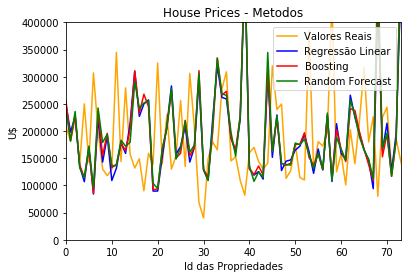

In [625]:
boosting = pd.DataFrame(pd.read_csv('result_bostingtree.csv'))
random = pd.DataFrame(pd.read_csv('result_randomforecast.csv'))
def stat3(df):
    y_train = train_origin["SalePrice"]
    y_boosting = boosting["SalePrice"]
    y_random = random["SalePrice"]
    y_pred = df["SalePrice"]
    plt.title('House Prices - Metodos')
    plt.ylabel('U$')
    plt.xlabel(u'Id das Propriedades')
    true_val, = plt.plot(y_train,color='orange', label='Valores Reais')
    linear_val, = plt.plot(y_pred,color='b',label=u'Regressão Linear')
    boosting_val, = plt.plot(y_boosting,color='red', label='Boosting')
    random_val, = plt.plot(y_random,color='g', label='Random Forecast')
    plt.xlim([0,73])
    plt.ylim([-100,400000])
    plt.legend(handles=[true_val,linear_val,boosting_val,random_val])
    plt.show()
stat3(predict_train)

<h2>Credits</h2>

https://github.com/Shitao/Kaggle-House-Prices-Advanced-Regression-Techniques<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data